In [2]:
using MLDataPattern
using Plots; pyplot()
using ProgressMeter
using JLD
import PyCall
using DrakeVisualizer, GeometryTypes, CoordinateTransformations
DrakeVisualizer.any_open_windows() || DrakeVisualizer.new_window()

Process(`/Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/DrakeVisualizer/src/../deps/usr/bin/drake-visualizer`, ProcessRunning)

In [20]:
import Nets
reload("Nets")

INFO: Recompiling stale cache file /Users/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/Nets.ji for module Nets.


In [9]:
include("../../pympc.jl")
colmat = PyMPC.colmat

Test Summary:    | Pass  Total
test sensitivity |  267    267


colmat (generic function with 1 method)

In [10]:
sys = PyMPC.Models.BoxAtlas()

PyMPC.Models.BoxAtlas(PyObject <pympc.models.boxatlas.BoxAtlasPWAModel object at 0x12f80eb90>)

In [11]:
vis = Visualizer()[:boxatlas]
setgeometry!(vis, sys)

Set{Array{Symbol,1}}()

In [12]:
controller = PyMPC.Models.controller(sys, Q=10*eye(10))

PyObject <pympc.control.MPCHybridController instance at 0x10a571908>

In [13]:
struct Sample
    utraj::Vector{Vector{Float64}}
    xtraj::Vector{Vector{Float64}}
    switching_sequence::Vector{Int}
    u_sensitivity::Matrix{Float64}
end

In [14]:
# num_samples = 100
# num_sim_steps = 20
# data = Vector{Sample}()
# # data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

# @showprogress for i in 1:num_samples
#     while true
#         x0 = PyMPC.Models.generate_x0(sys)
#         settransform!(vis, sys, x0)
#         utraj, xtraj, switching_sequence, J = PyMPC.run_mpc(controller, x0)
#         u = utraj[1]
#         if !isnan(u[1])
#             @assert x0 == xtraj[1]
#             PyMPC.Models.playback(vis, sys, xtraj, 1)
#             push!(data, Sample(utraj, xtraj, collect(switching_sequence), J[1:length(u), :]))
#             for j in 1:num_sim_steps
#                 x = xtraj[2]
#                 utraj = vcat(utraj[2:end], [zeros(utraj[end])])
#                 xnext = try
#                     vec(sys.sys[:pwa_system][:simulate](colmat(xtraj[end]), [colmat(utraj[end-1])])[1][2])
#                 catch e
#                     if isa(e, PyCall.PyError)
#                         zeros(xtraj[end])
#                     else
#                         rethrow(e)
#                     end
#                 end
#                 xtraj = vcat(xtraj[2:end], [xnext])
#                 switching_sequence = (switching_sequence[2:end]..., switching_sequence[end])
#                 utraj, xtraj, switching_sequence, J = PyMPC.run_mpc(controller, x, utraj, xtraj, switching_sequence)
#                 u = utraj[1]
#                 if isnan(u[1])
#                     break
#                 end
#                 @assert x == xtraj[1]
#                 push!(data, Sample(utraj, xtraj, collect(switching_sequence), J[1:length(u), :]))
#                 PyMPC.Models.playback(vis, sys, xtraj, 1)
#             end
#             break
#         end
#     end
#     save("box_atlas_100_traj.jld", "data", data)
# end

# save("box_atlas_100_traj.jld", "data", data)

In [16]:
samples = load("box_atlas_100_traj.jld")["data"];

In [18]:
function features(sample::Sample)
    u = sample.utraj[1]
    x = sample.xtraj[1]
    J = sample.u_sensitivity
    x, hcat(u, J)
end

features (generic function with 1 method)

In [21]:
data = features.(samples)
train_data, test_data = splitobs(shuffleobs(data), 0.5)

train_data_scaled, x_to_u, v_to_y = Nets.rescale(train_data)
u_to_x = inv(x_to_u)
y_to_v = inv(v_to_y)

AffineMap([0.583452 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.223544 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.502388 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.242955 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.272683 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.53283 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.153005 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.166951 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.154875], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [24]:
data[1][2]

9×11 Array{Float64,2}:
 -0.0        -0.0      -0.0          …  -0.0      -0.0      -0.0        
  0.64587    -0.0       0.515159        -0.0      -0.0       0.923383   
 -0.0        -0.0      -0.0             -0.0      -0.0      -0.0        
  1.01876    -0.0       1.93248e-15     -0.0      -0.0       1.82592e-14
  0.173778   -0.0      -0.0             -0.0      -0.0      -0.0        
  0.0917479  -0.0      -0.0          …  -2.69298  -0.0      -0.0        
 -0.380844   -1.18669  -0.0             -0.0      -2.41876  -0.0        
 -0.380844   -1.18669  -0.0             -0.0      -2.41876  -0.0        
 -0.0        -0.0      -0.0             -0.0      -0.0      -0.0        

In [108]:
widths = [10, 64, 64, 64, 32, 16, 9]
activation = Nets.leaky_relu

function sensitive_loss(λ)
    q = fill(λ, 1, widths[1] + 1)
    q[1] = 1.0 - λ
    (params, x, y) -> sum(abs2, q .* (Nets.predict_sensitivity(Nets.Net(Nets.Params(widths, params), activation), x) .- y))
end

sensitive_loss (generic function with 1 method)

In [109]:
start_params = 0.1 * randn(Nets.Params{Float64}, widths).data
nepoch = 200;

mean((xy->begin  # In[110], line 8:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 3.0077926848576007


INFO: The specified values for size and/or count will result in 10 unused data points
Progress:   0%|                                         |  ETA: 0:05:18INFO: The specified values for size and/or count will result in 10 unused data points
Progress:   1%|                                         |  ETA: 0:04:59INFO: The specified values for size and/or count will result in 10 unused data points
Progress:   2%|█                                        |  ETA: 0:04:51INFO: The specified values for size and/or count will result in 10 unused data points
Progress:   2%|█                                        |  ETA: 0:04:55INFO: The specified values for size and/or count will result in 10 unused data points
Progress:   2%|█                                        |  ETA: 0:04:52INFO: The specified values for size and/or count will result in 10 unused data points
Progress:   3%|█                                        |  ETA: 0:04:48INFO: The specified values for size and/or count will resu

Progress:  24%|██████████                               |  ETA: 0:03:44INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  24%|██████████                               |  ETA: 0:03:42INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  24%|██████████                               |  ETA: 0:03:41INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  25%|██████████                               |  ETA: 0:03:39INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  26%|██████████                               |  ETA: 0:03:37INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  26%|███████████                              |  ETA: 0:03:36INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  26%|███████████                              | 

Progress:  46%|███████████████████                      |  ETA: 0:02:38INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  46%|███████████████████                      |  ETA: 0:02:36INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  47%|███████████████████                      |  ETA: 0:02:35INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  48%|███████████████████                      |  ETA: 0:02:34INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  48%|████████████████████                     |  ETA: 0:02:32INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  48%|████████████████████                     |  ETA: 0:02:31INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  49%|████████████████████                     | 

Progress:  69%|████████████████████████████             |  ETA: 0:01:31INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  70%|████████████████████████████             |  ETA: 0:01:30INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  70%|█████████████████████████████            |  ETA: 0:01:29INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  70%|█████████████████████████████            |  ETA: 0:01:27INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  71%|█████████████████████████████            |  ETA: 0:01:26INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  72%|█████████████████████████████            |  ETA: 0:01:24INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  72%|██████████████████████████████           | 

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:24INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:22INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:21INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  94%|██████████████████████████████████████   |  ETA: 0:00:19INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:18INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:16INFO: The specified values for size and/or count will result in 10 unused data points
Progress:  95%|███████████████████████████████████████  | 

mean((xy->begin  # In[110], line 16:
            sum(abs2, net(xy[1]) .- (xy[2])[:, 1])
        end), test_data) = 0.6765000075433625



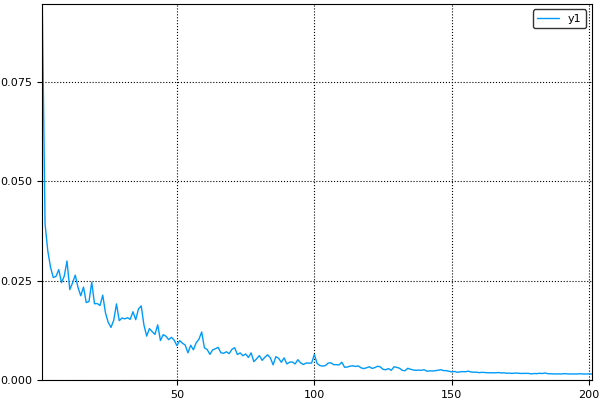

In [110]:
params = copy(start_params)
net = Nets.Net(Nets.Params(widths, params), activation, x_to_u, v_to_y)

train_loss = sensitive_loss(0.1)
validate_loss = train_loss
losses = [mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled)]

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

@showprogress for i in 1:nepoch
#     train_loss = sensitive_loss(0.1)
    Nets.adam!(train_loss, params, train_data_scaled, Nets.AdamOpts(learning_rate=0.01 * 0.99^i, batch_size=20))
    push!(losses, mean(xy -> validate_loss(params, xy[1], xy[2]), train_data_scaled))
end

@show mean(xy -> sum(abs2, net(xy[1]) .- xy[2][:,1]), test_data)

plot(losses, ylim=(0, losses[1]))

In [112]:
netcontroller = x -> clamp.(net(x), -1, 1)

(::#118) (generic function with 1 method)

In [101]:
x0 = PyMPC.Models.generate_x0(sys, controller)
@show x0

x0 = [0.17665, 0.149005, 0.109203, 0.112952, 0.0381778, 0.343083, 0.0437361, 0.287838, -0.697056, 0.244723]


10-element Array{Float64,1}:
  0.17665  
  0.149005 
  0.109203 
  0.112952 
  0.0381778
  0.343083 
  0.0437361
  0.287838 
 -0.697056 
  0.244723 

In [147]:
x0 = zeros(10)
x0[end-1] = -0.5
x0[end] = 0.5

0.5

In [113]:
x0 = [0.17665, 0.149005, 0.109203, 0.112952, 0.0381778, 0.343083, 0.0437361, 0.287838, -0.697056, 0.244723]

10-element Array{Float64,1}:
  0.17665  
  0.149005 
  0.109203 
  0.112952 
  0.0381778
  0.343083 
  0.0437361
  0.287838 
 -0.697056 
  0.244723 

In [150]:
xs = PyMPC.Models.simulate(sys, x0, netcontroller; N_sim=10)
PyMPC.Models.playback(vis, sys, xs)

LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, C_NULL)) <type 'exceptions.ValueError'>
ValueError('Unfeasible state x = [-0.16212523  0.05676549  0.          0.00827157  0.         -0.01029216\n -0.0599598  -0.00363991 -0.04872553 -0.09761276] or input u = [-0.0032219   0.01604866  0.00156959  0.01594736  0.02810052  0.01720296\n  0.18997839  0.15805161  0.00342992]',)
  File "/Users/rdeits/locomotion/explorations/learning-mpc/py-mpc/pympc/dynamical_systems.py", line 123, in simulate
    raise ValueError('Unfeasible state x = ' + str(x_list[k].flatten()) + ' or input u = ' + str(u_list[k].flatten()))
[39m

In [149]:
PyMPC.Models.playback(vis, sys, xs)